In [1]:
import sys
import os
import numpy as np
import multiprocessing
import dill
import matplotlib.pyplot as plt
import pandas as pd

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path + "/src/simulations_v2")
from load_params import load_params

from multi_group_simulation import MultiGroupSimulation

In [2]:
def get_cum_hosp(df):
    return df[['severity_3', 'severity_2']].iloc[df.shape[0] - 1].sum()

def get_cum_outside_infections(df):
    return df['cumulative_outside_infections'].iloc[df.shape[0] - 1].sum()

def get_cum_infections(df):
    return df[['cumulative_mild', 'cumulative_severe']].iloc[df.shape[0] - 1].sum()

def get_cum_inf_trajectory(df):
    return np.sum(df[['cumulative_mild', 'cumulative_severe']], axis=1)

def get_cum_hosp_trajectory(df):
    return np.sum(df[['severity_3', 'severity_2']], axis=1)

def get_cum_quarantine_isolation_trajectory(df):
    return np.sum(df[['QI','QS']], axis=1)

def get_cum_quarantine_trajectory(df):
    return df[['QS']]

def get_cum_isolation_trajectory(df):
    return df[['QI']]

def total_infections(list_sim_dfs):
    total = 0
    for sim_df in list_sim_dfs:
        total += get_cum_infections(sim_df)
    return total

def total_hosp(list_sim_dfs):
    total = 0
    for sim_df in list_sim_dfs:
        total += get_cum_hosp(sim_df)
    return total


In [3]:
# Fall Semester Group Config

# Loading group params
base_directory = '../src/simulations_v2/params/jan4calibration/'
# base_directory = '../src/simulations_v2/params/jan_12_send_to_mike/'

ug_ga_params = load_params(base_directory + 'group_1_students_post_movein_private.yaml')[1]
ug_other_params = load_params(base_directory + 'group_2_students_post_movein_private.yaml')[1]
gs_params = load_params(base_directory + 'group_3_students_post_movein_private.yaml')[1]
fs_params = load_params(base_directory + 'faculty_staff_post_movein_private.yaml')[1]
#params_list = [ug_ga_params.copy(), ug_other_params.copy(), gs_params.copy(), fs_params.copy()]
params_list = [ug_ga_params.copy(), ug_other_params.copy()]

/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


### Not modelling any grad students

In [5]:
# Scaling of the interaction matrix is wrong, made up number of f/s -> f/s contact
# interaction_matrix = np.array([[161/125, 2/44, 0],
#                               [8/125, 7/44, 0],
#                               [0,0,1/15]])

interaction_matrix = np.array([[161/125, 2/44],
                              [8/125, 7/44]])


total_UGs = 5000
# adding population size (total 5000 UGs)
params_list[0]['population_size'] = np.ceil(total_UGs * 3533 / (3533 + 8434))
params_list[1]['population_size'] = total_UGs - params_list[0]['population_size']
# params_list[2]['population_size'] = 6202
#params_list[3]['population_size'] = 10000

for idx in range(2):
    params_list[idx]['daily_outside_infection_p'] *= 2
#     params_list[idx]['test_protocol_QFNR'] = 1 - (0.75 * 0.95)

# Initially 12.4 free + infectious individuals (UG only)
# Assuming all returning students comply with arrival testing
UG_0_initial_cases = 3.66 * total_UGs / (3533 + 8434)
UG_1_initial_cases = 8.74 * total_UGs / (3533 + 8434)
# UG_2_initial_cases = 6.43

params_list[0]['initial_ID_prevalence'] = UG_0_initial_cases / params_list[0]['population_size']
params_list[1]['initial_ID_prevalence'] = UG_1_initial_cases / params_list[1]['population_size']
# params_list[2]['initial_ID_prevalence'] = UG_2_initial_cases / params_list[2]['population_size']

params_list[0]['exposed_infection_p'] = 0.24*1.56*1.25
params_list[1]['exposed_infection_p'] = 0.24*1.56*1.25

# group_names = ['UG (Greek, Athlete)', 'UG (other)', 'GS']#, 'Faculty/Staff']
group_names = ['UG (Greek, Athlete)', 'UG (other)']

In [6]:
from multiprocessing import Process
import pickle


def get_trajectories(transmission_p, test_compliance, n, T=19*7):
    
    for idx in range(2):
        params_list[idx]['exposed_infection_p'] = transmission_p
        params_list[idx]['test_protocol_QFNR'] = 1 - (0.6 * test_compliance)
    
    sim = MultiGroupSimulation(params_list, interaction_matrix, group_names)

    trajectories = list()
    
    for _ in range(n):
        sim.run_new_trajectory(T)
        group_results = []
        for group in sim.sims:
            df = group.sim_df
            group_results.append(df)
        trajectories.append(group_results)

    return trajectories

def sim_target_f(transmission_p, test_compliance, ntrajectories, pickle_file_loc):
    results = get_trajectories(transmission_p, test_compliance, ntrajectories)
    pickle.dump(results, open(pickle_file_loc, "wb"))

def run_sims_new_process(transmission_p, test_compliance, ntrajectories, pickle_file_loc):
    p = Process(target = sim_target_f, args = (transmission_p, test_compliance, ntrajectories, pickle_file_loc))
    p.start()
    return p


In [ ]:
base_transmission_p = 0.24 * 1.56 * 1.25
transmission_ps_to_try = [base_transmission_p * x for x in np.arange(0.75,1.26, 0.025)]
compliance_to_try = list(np.arange(0.6,1.01,0.025))

output_dir = "jan_13_virtual_contour_plot_transmission_compliance/"
ntrajectories = 50

processes = []

for transmission_p in transmission_ps_to_try:
    for compliance in compliance_to_try:
        filename = output_dir + "transmission_p_{}_compliance_{}.pickle".format(transmission_p, compliance)
        p = run_sims_new_process(transmission_p, compliance, ntrajectories, filename)
        processes.append(p)
    
print("launched {} processes".format(len(processes)))
for p in processes:
    p.join()

launched 357 processes


In [23]:

def extract_sim_properties(fname):
    sim_info = fname.split('transmission_p_')[-1]
    transmission_p = sim_info.split('_')[0]
    compliance = sim_info.split('_')[2]
    compliance = compliance.split('.pickle')[0]
    return float(transmission_p), float(compliance)

def load_sim_output(fname):
    with open(fname, "rb") as handle:
        sim_output = pickle.load(handle)
    return sim_output

def load_sim_outputs(sim_output_dir):
    sim_pickle_files = [sim_output_dir + '/' + file for  file in os.listdir(sim_output_dir) if '.pickle' in file]

    sim_outputs = {}
    for fname in sim_pickle_files:
        transmission_p, compliance = extract_sim_properties(fname)
        sim_output = load_sim_output(fname)
        sim_outputs[transmission_p, compliance] = sim_output

    print("Loaded {} simulation results".format(len(sim_outputs)))
    return sim_outputs

# output_dir = "jan_12_multigroup_sim_results_send_to_mike/"
sim_outputs = load_sim_outputs('./' + output_dir)

Loaded 357 simulation results


In [24]:
# sim_outputs.keys()
get_cum_infections(sim_outputs[(0.46800000000000014, 0.7000000000000001)][0][0]) + get_cum_infections(sim_outputs[(0.46800000000000014, 0.7000000000000001)][0][1])

909.0

In [25]:
def get_cum_sim_infxns(sim_output):
    infxns = list()
    for trajectory in sim_output:
        infxns.append(get_cum_infections(trajectory[0]) + get_cum_infections(trajectory[1]))
    return np.median(infxns)


Zs_inf = []

for transmission_p in transmission_ps_to_try:
    Z_inf = []
    for compliance in compliance_to_try:
        sim_trajs = sim_outputs[transmission_p, compliance]
        Z_inf.append(get_cum_sim_infxns(sim_trajs))
    Zs_inf.append(Z_inf)


<a list of 6 text.Text objects>

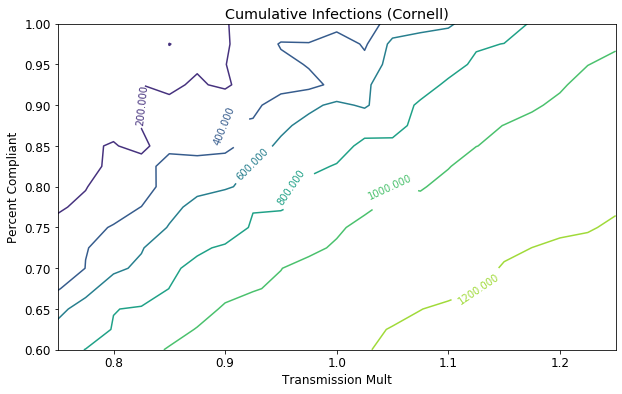

In [26]:

plt.figure(figsize=(10,6))
plt.title("Cumulative Infections (Cornell)")
plt.ylabel("Percent Compliant")
plt.xlabel("Transmission Mult")
CS = plt.contour(np.array(transmission_ps_to_try)/base_transmission_p, np.array(compliance_to_try), np.array(Zs_inf).T)
# CS = plt.contour(np.array(X_popsize), np.array(Y_testfrac) * 100, np.array(Zs_inf).T/34310, inf_levels)
# plt.clabel(CS, fmt=inf_labels, inline=1, fontsize=10)
plt.clabel(CS, inline=1, fontsize=10)